# Tokens cleaning and study

In [4]:
import sys
sys.path.append("..")

import json
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict

from src.dataset import Dataset

## Tokens analysis and cleaning

We start by loading the tokens and by plotting the document length.

In [2]:
dataset = Dataset()
tokens = dataset.load_dataset(tokens=True)

In [5]:
x = [len(x) for x in tokens]

fun = [max, min, np.mean, np.std]

print("Length stats:")
pprint([(f.__name__, f(x)) for f in fun])

Length stats:
[('max', 27407),
 ('min', 0),
 ('mean', 689.4474945501787),
 ('std', 737.3623651708255)]


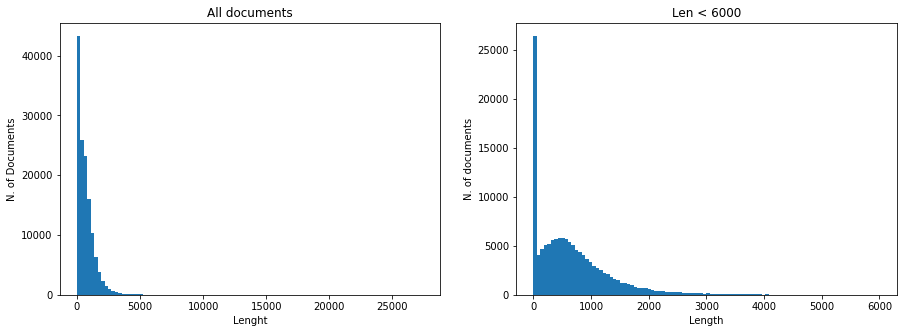

In [6]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(x, bins=100)
axs[1].hist(list(filter(lambda x:x<6000, x)), bins=100)
axs[0].set(title= "All documents", 
           xlabel="Lenght", ylabel="N. of Documents")
axs[1].set(title= "Len < 6000", 
           xlabel="Lenght", ylabel="N. of Documents")

plt.xlabel("Length")
plt.ylabel("N. of documents")
plt.show()

### Zipf curve

We start by computing the document frequency for each token, we can clearly see some tokens are heavily used, mean and max are really distant.

In [8]:
freqs = defaultdict(lambda:0)

for doc in tokens:
    for t in set(doc):
        freqs[t] += 1

freq_list = list(freqs.values())

In [9]:
print("Terms frequency stats:")
pprint([(f.__name__, f(freq_list)) for f in fun])
print(f"Vocabulary length: {len(freq_list)}")

Terms frequency stats:
[('max', 124337),
 ('min', 1),
 ('mean', 146.82070966499188),
 ('std', 1943.4805127292348)]
Vocabulary length: 249188


We now consider terms that appear at least min_cutoff times. 

In [40]:
max_cutoff = 0.9*len(tokens)
min_cutoff = 2

h = lambda x : min_cutoff <= x <= max_cutoff
nh = lambda x : x < min_cutoff or x > max_cutoff

filtered_freq_list = list(filter(h, freq_list))
print("Filtered terms frequency stats:")
pprint([(f.__name__, f(filtered_freq_list)) for f in fun])
len(filtered_freq_list)

Filtered terms frequency stats:
[('max', 122080),
 ('min', 2),
 ('mean', 321.274129498439),
 ('std', 2851.654657663967)]


113067

In [13]:
print(f"The most common term appears in the {round(max(filtered_freq_list)/len(tokens), 2)}% of documents.")
print(f"There are {len(list(filter(nh, freq_list)))} terms that appear more than {int(min_cutoff)} times.")

The most common term appears in the 0.9% of documents.
There are 62733 terms that appear more than 5 times.


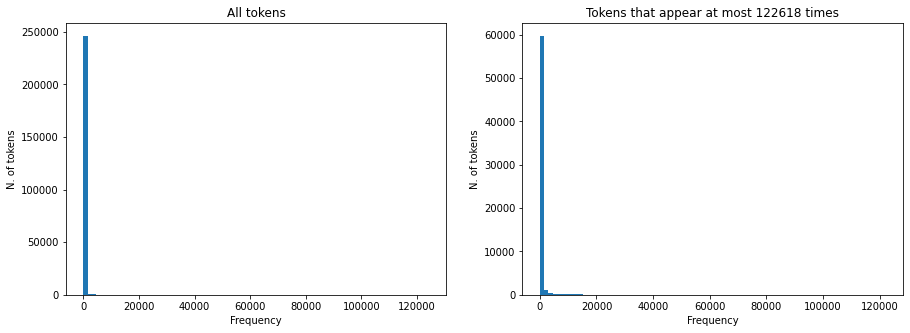

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(freq_list, bins=80)
axs[1].hist(filtered_freq_list, bins=80)
axs[0].set(title= "All tokens", 
           xlabel="Frequency", ylabel="N. of tokens")
axs[1].set(title= f"Tokens that appear at most {int(max_cutoff)} times", 
           xlabel="Frequency", ylabel="N. of tokens")

plt.show()

## Searching terms about three topics

We start by checking for the presence of drugs, weapons and investigation terms.

In [34]:
narcotics = ['cannabis',
             'cocaine',
             'methamphetamine',
             'drugs',
             'drug',
             'marijuana',
             'ecstasy',
             'lsd',
             'ketamine',
             'heroin',
             'fentanyl', 
             'overdose', 
             'od']

weapons = ['gun',
           'knife',
           'weapon',
           'firearm',
           'rifle',
           'carabine',
           'shotgun',
           'handgun',
           'revolver',
           'musket',
           'pistol',
           'derringer',
           'assault',
           'rifle',
           'sword',
           'blunt']

investigation = ['gang',
                 'mafia',
                 'serial', 
                 'killer',
                 'rape',
                 'theft',
                 'recidivism',
                 'arrest',
                 'robbery',
                 'cybercrime',
                 'cyber', 
                #  'caucasian','afro-american','native', 'american','hispanic','male','female','man','woman','girl','boy',
                 'crime']

### Collect and remove unused terms

The vocabulary drastically shrinks from 450k to 71k words by filtering out the terms that appears less than 9 times, this can be seen in later vectorization, but also from the stats presented above.

In [46]:
irrelevant_terms = set([ k for k,v in freqs.items() if nh(v)])

for e in weapons + investigation + narcotics:
    if e in irrelevant_terms:
        irrelevant_terms.remove(e)

print(len(irrelevant_terms))
list(irrelevant_terms)[:10]

136120


['postee',
 'maubrey',
 'opporttinity',
 'ioould',
 'faunniquet',
 'matkin',
 'coünt',
 'orcibility',
 'mcpride',
 'ogilivie']

In [43]:
filtered_tokens = [[t for t in doc if t not in irrelevant_terms] for doc in tokens]

In [69]:
with open("../data/processed/filtered_tokens_cleaner.json", "w") as f: 
    f.write(json.dumps(filtered_tokens))
    
# filtered_tokens = json.load(open("../data/processed/filtered_tokens.json", "r"))

In [47]:
seen = set()
not_found = set(weapons + investigation + narcotics)
freq = defaultdict(lambda:0)
for doc in filtered_tokens:
    # if not not_found:
    #     break
    for w in set(doc): 
        if w in not_found:
            # not_found.remove(w)
            seen.add(w)
            freq[w] += 1

In [45]:
pprint(sorted([(v,k) for k,v in freq.items()]))
print("Not found")
pprint(not_found-seen)

[(5, 'mafia'),
 (5, 'musket'),
 (7, 'methamphetamine'),
 (13, 'recidivism'),
 (19, 'drugs'),
 (22, 'od'),
 (29, 'derringer'),
 (55, 'overdose'),
 (85, 'lsd'),
 (135, 'cocaine'),
 (135, 'killer'),
 (168, 'sword'),
 (174, 'handgun'),
 (210, 'blunt'),
 (272, 'cannabis'),
 (402, 'serial'),
 (426, 'rifle'),
 (503, 'firearm'),
 (527, 'marijuana'),
 (639, 'gang'),
 (695, 'shotgun'),
 (710, 'heroin'),
 (1455, 'pistol'),
 (1552, 'knife'),
 (1667, 'revolver'),
 (1797, 'rape'),
 (2599, 'drug'),
 (2673, 'theft'),
 (2943, 'weapon'),
 (3493, 'assault'),
 (4172, 'gun'),
 (4607, 'robbery'),
 (11996, 'crime'),
 (12517, 'arrest')]
Not found
{'ecstasy', 'ketamine', 'fentanyl', 'carabine', 'cyber', 'cybercrime'}
